In [1]:
import sys
sys.path.append("/ocean/projects/cis240129p/soederha/silent_speech")

import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Subset, ConcatDataset
from pathlib import Path
import numpy as np
from lib_alice import BrennanDataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm

base_dir = Path("/ocean/projects/cis240129p/shared/data/eeg_alice")
#subjects_used = ['S01', 'S03', 'S04', 'S06', 'S08', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'S22', 'S25', 'S26', 'S34', 'S35', 'S36', 'S37', 'S39', 'S40', 'S41', 'S42', 'S44', 'S45', 'S48']  # exclude 'S05' - less channels

subjects_used =['S04', 'S09', 'S13', 'S17', 'S20']

#38 doesn'r work

In [2]:
torch.cuda.empty_cache()

In [3]:
def create_datasets(subjects, base_dir, augmented_eeg_dict = None):
    train_datasets = []
    test_datasets = []
    for subject in subjects:
        dataset = BrennanDataset(
            root_dir=base_dir,
            phoneme_dir=base_dir / "phonemes",
            idx=subject,
            phoneme_dict_path=base_dir / "phoneme_dict.txt",
            augmented_eeg_dict=augmented_eeg_dict,
        )
        num_data_points = len(dataset)

        # Split indices into train and test sets
        split_index = int(num_data_points * 0.8)
        train_indices = list(range(split_index))
        test_indices = list(range(split_index, num_data_points))

        # Create Subset datasets using indices
        train_dataset = Subset(dataset, train_indices)
        test_dataset = Subset(dataset, test_indices)

        train_datasets.append(train_dataset)
        test_datasets.append(test_dataset)
    return train_datasets, test_datasets


train_ds, test_ds = create_datasets(subjects_used, base_dir)
train_dataset = ConcatDataset(train_ds)
test_dataset = ConcatDataset(test_ds)
print(
    f"Train dataset length: {len(train_dataset)}, Test dataset length: {len(test_dataset)}"
)

Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S04.vhdr...
Setting channel info structure...
Reading 0 ... 368449  =      0.000 ...   736.898 secs...
Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S09.vhdr...
Setting channel info structure...
Reading 0 ... 368699  =      0.000 ...   737.398 secs...
Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S13.vhdr...
Setting channel info structure...
Reading 0 ... 368274  =      0.000 ...   736.548 secs...
Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S17.vhdr...
Setting channel info structure...
Reading 0 ... 365649  =      0.000 ...   731.298 secs...
Extracting parameters from /ocean/projects/cis240129p/shared/data/eeg_alice/S20.vhdr...
Setting channel info structure...
Reading 0 ... 368424  =      0.000 ...   736.848 secs...
Train dataset length: 8515, Test dataset length: 2130


In [4]:
print(train_dataset[2])

{'label': 'beginning', 'audio_feats': array([[ -9.501374 ,  -9.728448 , -10.021716 , ...,  -6.9363112,
         -7.046369 , -10.906834 ],
       [ -9.535726 ,  -9.078351 ,  -8.7449045, ...,  -7.1128097,
         -8.158176 , -11.344505 ],
       [-11.360717 , -10.381192 ,  -9.873763 , ...,  -8.014458 ,
         -9.281037 , -11.204559 ],
       ...,
       [ -7.576384 ,  -7.801605 ,  -8.088927 , ..., -11.23759  ,
        -11.469321 , -11.512723 ],
       [ -9.226811 ,  -8.89115  ,  -8.620725 , ..., -11.165502 ,
        -11.387218 , -11.511845 ],
       [ -8.664348 ,  -8.714449 ,  -8.755628 , ..., -11.25327  ,
        -11.440603 , -11.509818 ]], dtype=float32), 'audio_raw': array([-0.00564938,  0.03451216, -0.04623905, ..., -0.01230818,
       -0.01343718, -0.01837567]), 'eeg_raw': array([[ 0.13822063,  0.11013473,  0.18283209, ...,  0.24540294,
         0.8581372 ,  0.47406291],
       [ 0.50044492,  0.6891782 ,  0.84550396, ...,  0.5369736 ,
        -0.14992252, -0.0052803 ],
       [ 0

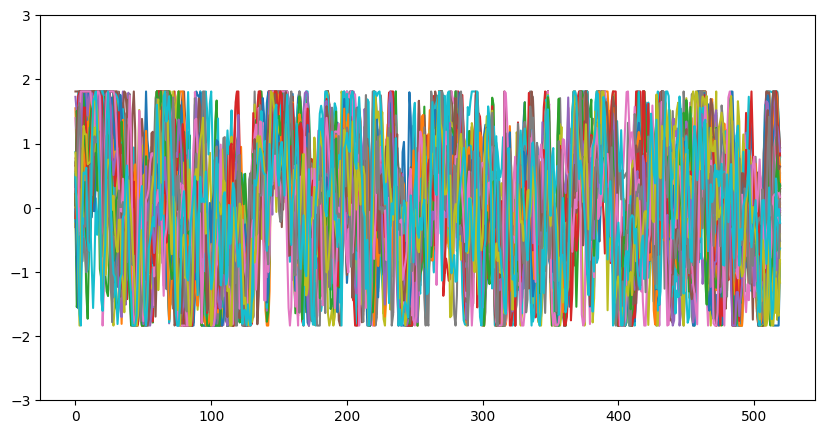

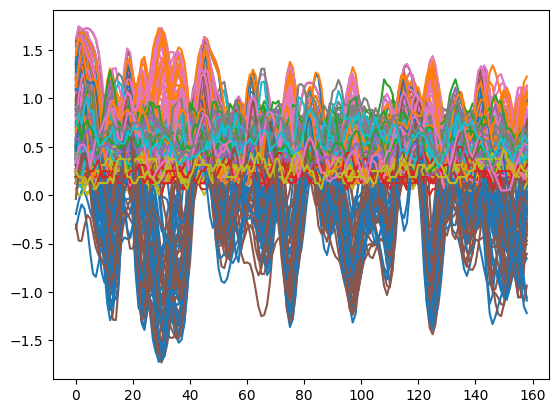

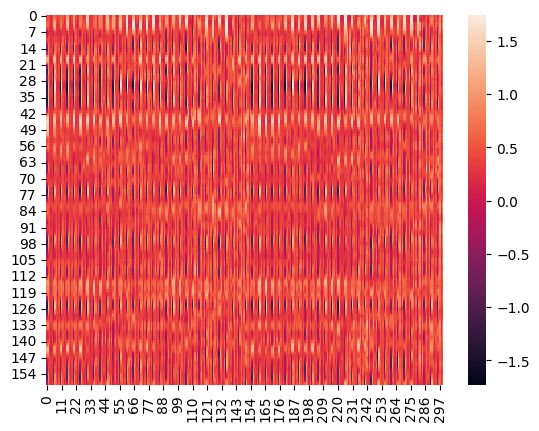

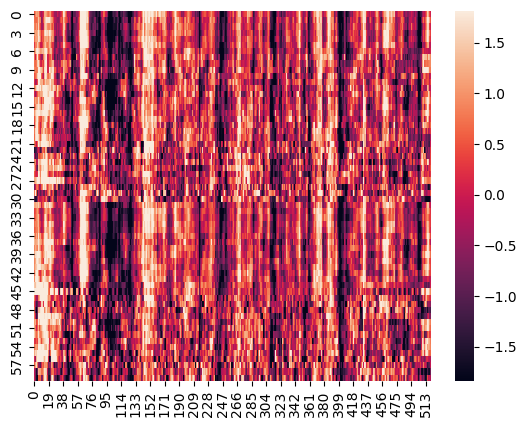

In [5]:
#plot eeg raw vs eeg feat

eeg_raw = train_dataset[2]["eeg_raw"]
eeg_feat = train_dataset[2]["eeg_feats"]

plt.figure(figsize=(10, 5))
plt.ylim(-3, 3)
plt.plot(eeg_raw)
plt.show()

plt.plot(eeg_feat)
plt.show()

import seaborn as sns

sns.heatmap(eeg_feat)
plt.show()

sns.heatmap(eeg_raw.T)
plt.show()

In [6]:
def collate_fn(batch):
    """
    A custom collate function that handles different types of data in a batch.
    It dynamically creates batches by converting arrays or lists to tensors and
    applies padding to variable-length sequences.
    """
    batch_dict = {}
    for key in batch[0].keys():
        batch_items = [item[key] for item in batch]
        if isinstance(batch_items[0], np.ndarray) or isinstance(
            batch_items[0], torch.Tensor
        ):
            if isinstance(batch_items[0], np.ndarray):
                batch_items = [torch.tensor(b) for b in batch_items]
            if len(batch_items[0].shape) > 0:
                batch_dict[key] = torch.nn.utils.rnn.pad_sequence(
                    batch_items, batch_first=True  # pad with zeros
                )
            else:
                batch_dict[key] = torch.stack(batch_items)
        else:
            batch_dict[key] = batch_items

    return batch_dict


train_dataloder = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
)

test_dataloder = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    num_workers=1,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=True,
)

In [7]:
i=0
for batch in train_dataloder:
    print(type(batch))
    print(batch.keys())
    print(batch['eeg_raw'].shape)
    #print(batch['label'])
    #print(batch['eeg_feats'].shape)
    
    print(batch['label'])
    i+=1
    if i>1:
        break

<class 'dict'>
dict_keys(['label', 'audio_feats', 'audio_raw', 'eeg_raw', 'eeg_feats', 'phonemes', 'eeg_augmented'])
torch.Size([2, 520, 60])
['fall', 'orange']
<class 'dict'>
dict_keys(['label', 'audio_feats', 'audio_raw', 'eeg_raw', 'eeg_feats', 'phonemes', 'eeg_augmented'])
torch.Size([2, 520, 60])
['a', 'table']


In [8]:
class EEGAutoencoder(nn.Module):
    def __init__(self, sequence_lenth=520, feature_dim=60,latent_dim=256):
        super(EEGAutoencoder, self).__init__()
        
        self.input_dim = sequence_lenth * feature_dim
        self.sequence_length = sequence_lenth
        self.feature_dim = feature_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, 4096),
            nn.ReLU(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
        )
        
        
        '''self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,1), padding=(1,1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )'''
        
        #for convolutional
        '''x = torch.randn(1, 1, self.sequence_length, feature_dim)
        x = self.encoder(x)
        self.flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
        self.conv_shape = x.shape[1:]'''
        
        # Latent space
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_var = nn.Linear(1024, latent_dim)
        
        # Decoder
        '''self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, self.input_dim),
            nn.Tanh()
        )'''
        
        #self.decoder_input = nn.Linear(latent_dim, 1024)
        
        '''self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=(3,3), stride=(2,1), padding=(1,1), output_padding=(1,0)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=(3,3), stride=(2,1), padding=(1,1), output_padding=(1,0)),
            
        )'''
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
            nn.ReLU(),
            nn.Linear(4096, self.input_dim),
        )
        
        
        
    def encode(self, x):
        x = x.view(x.size(0), -1)  #flattens to 2dim, for linear layers
        #x = x.unsqueeze(1)   #for convolutional
        x = self.encoder(x) 
        #x = x.view(x.size(0), -1)    #for convolutional
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    #decode for linear
    '''def decode(self, z):
        x = self.decoder(z)
        return x.view(-1, self.sequence_length, self.feature_dim)'''
        
    #decode for convolutional
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, *self.conv_shape)
        x = self.decoder(x)
        return x.squeeze(1)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def train_eeg_vae(model, train_loader, optimizer, device, epoch, data_type='eeg_raw'):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kld_loss = 0.0
    
    batch_pbar = tqdm(train_dataloder, desc=f'Epoch {epoch}', leave=False)
    
    for batch_idx, batch in enumerate(batch_pbar):
        eeg_feats = batch[data_type].float().to(device)
        optimizer.zero_grad()
        
        #Forward
        recon_batch, mu, log_var = model(eeg_feats)
        
        #Loss
        #reconstruction_loss = F.mse_loss(recon_batch, eeg_feats.view(recon_batch.shape), reduction='sum')
        reconstruction_loss = F.mse_loss(recon_batch, eeg_feats, reduction='sum')/eeg_feats.shape[0]
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())/eeg_feats.shape[0]
        
        #Total loss
        beta = 0.1  # control KL divergence impact
        loss = reconstruction_loss + beta * kld_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon_loss += reconstruction_loss.item()
        total_kld_loss += kld_loss.item()
        
        running_loss += loss.item()
        current_loss = running_loss / (batch_idx + 1)
        
        running_recon_loss += reconstruction_loss.item()
        current_recon_loss = running_recon_loss / (batch_idx + 1)
        
        running_kld_loss += kld_loss.item()
        current_kld_loss = running_kld_loss / (batch_idx + 1)
        
        batch_pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'recon': f'{current_recon_loss:.4f}',
                'kld': f'{current_kld_loss:.4f}'
            })
        
        
        
        '''if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}]\t'
                  f'Loss: {loss.item() / len(eeg_feats):.6f}'
                  f'Reconstruction Loss: {reconstruction_loss.item() / len(eeg_feats):.6f}'
                  f'KLD Loss: {kld_loss.item() / len(eeg_feats):.6f}')
          '''  
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss

In [9]:
class EEGAutoencoder(nn.Module):
    def __init__(self, sequence_length=520, feature_dim=60, latent_dim=64):
        super(EEGAutoencoder, self).__init__()
        
        self.sequence_length = sequence_length
        self.feature_dim = feature_dim
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), stride=(2,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,1), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        # Calculate flattened size
        x = torch.randn(1, 1, self.sequence_length, feature_dim)
        x = self.encoder(x)
        print(f"Encoded shape: {x.shape}")  # Debug print
        self.flattened_size = x.shape[1] * x.shape[2] * x.shape[3]
        self.conv_shape = x.shape[1:]
        
        # Latent space
        self.fc_mu = nn.Linear(self.flattened_size, latent_dim)
        self.fc_var = nn.Linear(self.flattened_size, latent_dim)
        
        # Decoder input
        self.decoder_input = nn.Linear(latent_dim, self.flattened_size)
        
        # Decoder with modified output padding in last layer
        #Padding 1,1 for 3x3 kernel
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=(2,1), 
                             padding=(1,1), output_padding=(1,0)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=(3,3), stride=(2,1), 
                             padding=(1,1), output_padding=(1,0)),  # Added output_padding (1,0) for eeg raw
        )
        
        # Test forward pass to verify shapes
        with torch.no_grad():
            test_input = torch.randn(1, 1, sequence_length, feature_dim)
            test_encoded = self.encoder(test_input)
            #print(f"Test encoded shape: {test_encoded.shape}")
            test_output = self.forward(test_input)[0]
            #print(f"Test output shape: {test_output.shape}")
    
    def encode(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        return mu
    
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, *self.conv_shape)
        x = self.decoder(x)
        return x.squeeze(1)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon = self.decode(z)
        # Debug prints
        #print(f"Input shape: {x.shape}")
        #print(f"Recon shape: {recon.shape}")
        return recon, mu, log_var
    
def train_eeg_vae(model, train_loader, optimizer, device, epoch, data_type='eeg_raw'):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    running_loss = 0.0
    running_recon_loss = 0.0
    running_kld_loss = 0.0
    
    batch_pbar = tqdm(train_dataloder, desc=f'Epoch {epoch}', leave=False)
    
    for batch_idx, batch in enumerate(batch_pbar):
        eeg_feats = batch[data_type].float().to(device)
        optimizer.zero_grad()
        
        #Forward
        recon_batch, mu, log_var = model(eeg_feats)
        
        #Loss
        #reconstruction_loss = F.mse_loss(recon_batch, eeg_feats.view(recon_batch.shape), reduction='sum')
        reconstruction_loss = F.mse_loss(recon_batch, eeg_feats, reduction='sum')/eeg_feats.shape[0]
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())/eeg_feats.shape[0]
        
        #Total loss
        beta = 0.1  # control KL divergence impact
        loss = reconstruction_loss + beta * kld_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_recon_loss += reconstruction_loss.item()
        total_kld_loss += kld_loss.item()
        
        running_loss += loss.item()
        current_loss = running_loss / (batch_idx + 1)
        
        running_recon_loss += reconstruction_loss.item()
        current_recon_loss = running_recon_loss / (batch_idx + 1)
        
        running_kld_loss += kld_loss.item()
        current_kld_loss = running_kld_loss / (batch_idx + 1)
        
        batch_pbar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'recon': f'{current_recon_loss:.4f}',
                'kld': f'{current_kld_loss:.4f}'
            })
        
        
        
        '''if batch_idx % 10 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx}]\t'
                  f'Loss: {loss.item() / len(eeg_feats):.6f}'
                  f'Reconstruction Loss: {reconstruction_loss.item() / len(eeg_feats):.6f}'
                  f'KLD Loss: {kld_loss.item() / len(eeg_feats):.6f}')
          '''  
    avg_loss = total_loss / len(train_loader.dataset)
    return avg_loss

'''def train_eeg_vae(model, train_loader, optimizer, device, epoch, beta=0.1, data_type='eeg_raw'):
    model.train()
    total_loss = 0
    total_recon_loss = 0
    total_kld_loss = 0
    
    batch_pbar = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)
    
    for batch_idx, batch in enumerate(batch_pbar):
        eeg_feats = batch[data_type].float().to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = model(eeg_feats)
        
        # Losses
        reconstruction_loss = F.mse_loss(recon_batch, eeg_feats, reduction='sum')
        kld_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total loss
        loss = reconstruction_loss + beta * kld_loss
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update metrics
        total_loss += loss.item()
        total_recon_loss += reconstruction_loss.item()
        total_kld_loss += kld_loss.item()
        
        batch_pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'recon': f'{reconstruction_loss.item():.4f}',
            'kld': f'{kld_loss.item():.4f}'
        })
    
    # Calculate average losses
    n_batches = len(train_loader)
    avg_loss = total_loss / n_batches
    avg_recon_loss = total_recon_loss / n_batches
    avg_kld_loss = total_kld_loss / n_batches
    
    return avg_loss, avg_recon_loss, avg_kld_loss'''

"def train_eeg_vae(model, train_loader, optimizer, device, epoch, beta=0.1, data_type='eeg_raw'):\n    model.train()\n    total_loss = 0\n    total_recon_loss = 0\n    total_kld_loss = 0\n    \n    batch_pbar = tqdm(train_loader, desc=f'Epoch {epoch}', leave=False)\n    \n    for batch_idx, batch in enumerate(batch_pbar):\n        eeg_feats = batch[data_type].float().to(device)\n        optimizer.zero_grad()\n        \n        # Forward pass\n        recon_batch, mu, log_var = model(eeg_feats)\n        \n        # Losses\n        reconstruction_loss = F.mse_loss(recon_batch, eeg_feats, reduction='sum')\n        kld_loss = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())\n        \n        # Total loss\n        loss = reconstruction_loss + beta * kld_loss\n        \n        # Backward pass\n        loss.backward()\n        optimizer.step()\n        \n        # Update metrics\n        total_loss += loss.item()\n        total_recon_loss += reconstruction_loss.item()\n        tot

In [10]:
torch.cuda.empty_cache()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

model = EEGAutoencoder(sequence_length=520, feature_dim=60, latent_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

from torchsummaryX import summary
test =  torch.zeros(2, 520, 60).to(device)
summary(model, test)

num_epochs = 1
train_losses = []
for epoch in range(1, num_epochs + 1):
    train_loss = train_eeg_vae(model, train_dataloder, optimizer, device, epoch, data_type='eeg_raw')
    train_losses.append(train_loss)
    print(f'====> Epoch: {epoch} Average loss: {train_loss:.4f}')

Device: cuda
Encoded shape: torch.Size([1, 128, 130, 60])
----------------------------------------------------------------------------------------------------
Layer                   Kernel Shape         Output Shape         # Params (K)      # Mult-Adds (M)
0_Conv2d               [1, 64, 3, 3]     [2, 64, 260, 60]                 0.64                 8.99
1_BatchNorm2d                   [64]     [2, 64, 260, 60]                 0.13                 0.00
2_ReLU                             -     [2, 64, 260, 60]                    -                    -
3_Conv2d             [64, 128, 3, 3]    [2, 128, 130, 60]                73.86               575.08
4_BatchNorm2d                  [128]    [2, 128, 130, 60]                 0.26                 0.00
5_ReLU                             -    [2, 128, 130, 60]                    -                    -
6_Linear                [998400, 64]              [2, 64]            63,897.66                63.90
7_Linear                [998400, 64]     

Epoch 1:   0%|          | 0/4257 [00:00<?, ?it/s]

====> Epoch: 1 Average loss: 46983.0435


In [12]:
def get_latent_by_word(model, train_dataloder, word_target):
    """
    Get the mean latent vector for a specific word from the training data
    """
    model.eval()
    device = next(model.parameters()).device
    
    word_latents = []
    
    with torch.no_grad():
        for batch in tqdm(train_dataloder):
            labels = batch['label']
            eeg_feats = batch['eeg_raw'].float().to(device)
            
            # Find indices of the word target
            word_indices = [i for i, label in enumerate(labels) if label == word_target]
            
            if word_indices:
                # EEG features for the word
                word_eeg = eeg_feats[word_indices]
                
                # latent representations
                mu, _ = model.encode(word_eeg)
                word_latents.append(mu)
    if word_latents:
        word_latents = torch.cat(word_latents, dim=0)
        mean_latent = torch.mean(word_latents, dim=0)
        var_latent = torch.var(word_latents, dim=0)
        return mean_latent, var_latent
    else:
        return None, None

def generate_eeg_from_word(model, word, train_dataloder, num_samples=5):
    """
    Generate new EEG features for a given word
    """
    model.eval()
    device = next(model.parameters()).device
    
    # Get mean and variance of latent vectors for this word
    mean_latent, var_latent = get_latent_by_word(model, train_dataloder, word)
    
    if mean_latent is None:
        print(f"No samples found for word: {word}")
        return None
    
    # Generate samples
    generated_samples = []
    with torch.no_grad():
        for i in range(num_samples):
            # Sample from the word's latent distribution
            eps = torch.randn_like(var_latent)
            z = mean_latent + eps * torch.sqrt(var_latent)
            
            # Generate new EEG features
            generated = model.decode(z.unsqueeze(0))
            generated_samples.append(generated)
    
    return torch.cat(generated_samples, dim=0)

def analyze_generated_samples(model, word, train_dataloder, num_samples=5):
    """
    Generate a number of eeg data samples for a word and returns both original and new
    """
    #real samples
    real_samples = []
    real_found = False
    
    for batch in train_dataloder:
        labels = batch['label']
        eeg_feats = batch['eeg_raw']
        
        
        word_indices = [i for i, label in enumerate(labels) if label == word]
        if word_indices:
            real_found = True
            real_samples.append(eeg_feats[word_indices])
    
    if not real_found:
        print(f"No real samples found for word: {word}")
        return
    
    real_samples = torch.cat(real_samples, dim=0)
    
    #new samples
    generated_samples = generate_eeg_from_word(model, word, train_dataloder, num_samples)
    
    if generated_samples is None:
        return
        
    '''print(word)
    print("Real samples shape:", real_samples.shape)
    print("Generated samples shape:", generated_samples.shape)'''
    
    real_mean = torch.mean(real_samples, dim=0)
    real_std = torch.std(real_samples, dim=0)
    gen_mean = torch.mean(generated_samples, dim=0)
    gen_std = torch.std(generated_samples, dim=0)
    
    print("\nStatistics:")
    print(f"Real mean range: [{torch.min(real_mean):.3f}, {torch.max(real_mean):.3f}]")
    print(f"Generated mean range: [{torch.min(gen_mean):.3f}, {torch.max(gen_mean):.3f}]")
    print(f"Real std range: [{torch.min(real_std):.3f}, {torch.max(real_std):.3f}]")
    print(f"Generated std range: [{torch.min(gen_std):.3f}, {torch.max(gen_std):.3f}]")
    
    return real_samples, generated_samples


In [59]:
get_latent_by_word(model, train_dataloder, 'Alice')

  0%|          | 0/4257 [00:00<?, ?it/s]

(tensor([ 2.3863, -2.7398,  2.4463,  1.3317, -2.7356,  1.6474, -2.6633, -2.6470,
          1.8889,  2.2954,  2.5513,  2.4825, -2.1151, -1.9384,  2.3151, -2.3115,
         -2.0557, -2.4524,  1.3766,  1.2545,  1.8217, -2.1208,  1.8053,  1.9421,
         -2.2670, -2.3732, -2.9134,  1.5780,  2.0538, -1.5239,  2.3850,  1.5333,
          1.9565, -1.8260,  2.4760, -1.8631,  2.0434, -2.7617,  2.2021,  2.1448,
          2.2657, -2.2926, -1.6246,  1.6871,  1.6397, -2.0107, -2.2367,  2.0397,
          1.9038,  1.6879, -2.7173,  2.2199, -2.0551,  3.5231, -2.3018,  0.8918,
         -1.4784,  2.0758, -1.9312, -1.5769,  1.7794,  2.1729, -2.2576,  2.1485],
        device='cuda:0'),
 tensor([0.0674, 0.0259, 0.0349, 0.3786, 0.0312, 0.1824, 0.0223, 0.0533, 0.0977,
         0.0702, 0.0176, 0.0656, 0.0347, 0.0582, 0.0610, 0.0863, 0.3161, 0.0369,
         0.2334, 0.4307, 0.1386, 0.0488, 0.1086, 0.2425, 0.1284, 0.0460, 0.0327,
         0.1375, 0.0524, 0.2419, 0.0463, 0.1648, 0.1430, 0.1273, 0.0380, 0.0871,
 

In [60]:
samples = generate_eeg_from_word(model, 'Alice', train_dataloder, num_samples=5)
print(samples.shape) #torch.Size([5, 159, 310])

  0%|          | 0/4257 [00:00<?, ?it/s]

torch.Size([5, 159, 300])


In [26]:
real_alice, generated_alice = analyze_generated_samples(model, 'Alice', train_dataloder, num_samples=1)

  0%|          | 0/4257 [00:00<?, ?it/s]

/var/tmp/ipykernel_104122/1439741832.py:98: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  gen_std = torch.std(generated_samples, dim=0)



Statistics:
Real mean range: [-0.401, 0.339]
Generated mean range: [-0.551, 0.598]
Real std range: [0.417, 1.360]
Generated std range: [nan, nan]


think
Real mean range: [-0.062, 0.627]
Generated mean range: [-0.035, 0.589]
Real std range: [0.000, 0.238]
Generated std range: [0.000, 0.072]

Alice
Real mean range: [-0.041, 0.625]
Generated mean range: [-0.033, 0.592]
Real std range: [0.000, 0.202]
Generated std range: [0.000, 0.077]

In [27]:
def plot_eeg_comparison(real_samples, generated_samples, word):
    plt.figure(figsize=(15, 5))
    
    # Plot real samples
    plt.subplot(1, 2, 1)
    for i in range(real_samples.shape[2]):
        plt.plot(real_samples[0, :, i].cpu().numpy(), alpha=0.5)
    plt.title(f'Real EEG for "{word}"')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    # Plot generated samples
    plt.subplot(1, 2, 2)
    for i in range(generated_samples.shape[2]):
        plt.plot(generated_samples[0, :, i].cpu().numpy(), alpha=0.5)
    plt.title(f'Generated EEG for "{word}"')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()

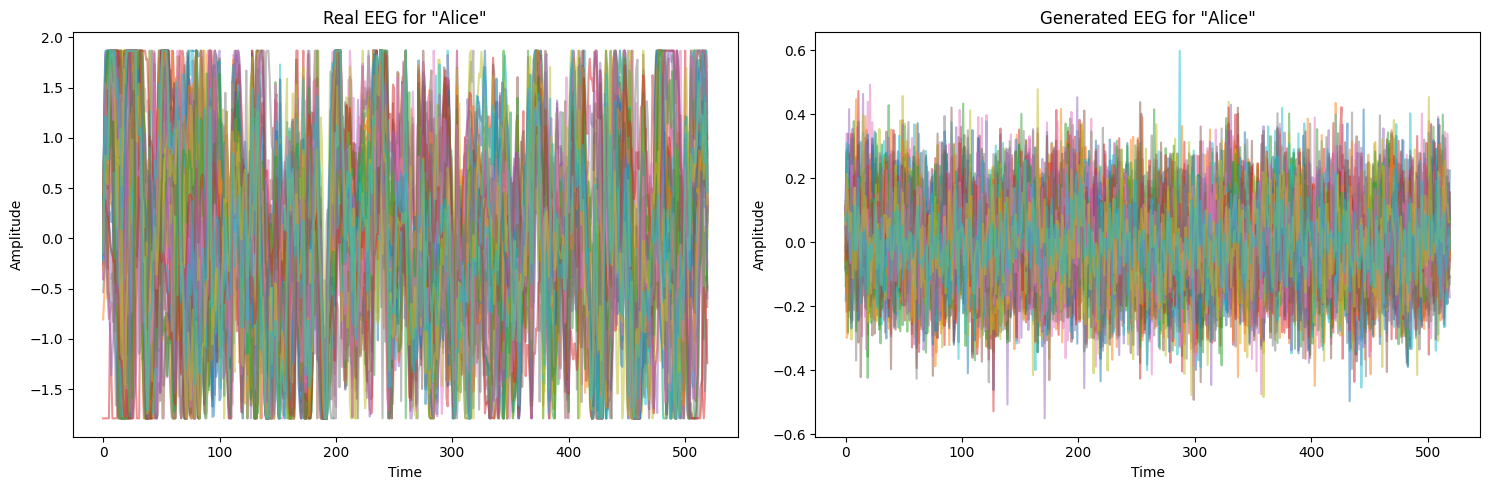

In [28]:

plot_eeg_comparison(real_alice, generated_alice, 'Alice')

In [29]:
import seaborn as sns


def plot_eeg_heatmaps(real_sample, generated_sample, word):
   """
   Plot heatmap comparisons between real and generated EEG data
   
   Args:
       real_sample: Tensor of shape [sequence_length, feature_dim] containing real EEG data
       generated_sample: Tensor of shape [sequence_length, feature_dim] containing generated EEG data
       word: String indicating which word the samples represent
   """
   # Create figure
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
   
   # Plot real sample heatmap
   sns.heatmap(real_sample.cpu().numpy().T, 
               ax=ax1, 
               cmap='viridis',
               cbar_kws={'label': 'Amplitude'})
   ax1.set_title(f'Real EEG Pattern for "{word}"')
   ax1.set_xlabel('Time')
   ax1.set_ylabel('Features')
   
   # Plot generated sample heatmap
   sns.heatmap(generated_sample.cpu().numpy().T, 
               ax=ax2, 
               cmap='viridis',
               cbar_kws={'label': 'Amplitude'})
   ax2.set_title(f'Generated EEG Pattern for "{word}"')
   ax2.set_xlabel('Time')
   ax2.set_ylabel('Features')
   
   plt.tight_layout()
   plt.show()
   
   # Plot difference heatmap
   '''plt.figure(figsize=(10, 8))
   difference = real_sample.cpu().numpy() - generated_sample.cpu().numpy()
   sns.heatmap(difference, 
               cmap='RdBu',
               center=0,
               cbar_kws={'label': 'Difference (Real - Generated)'})
   plt.title(f'Difference Map for "{word}"')
   plt.xlabel('Features')
   plt.ylabel('Time Steps')
   plt.show()'''
   
   '''# Print statistics
   print(f"\nStatistics for {word}:")
   print(f"Real data range: [{real_sample.min():.3f}, {real_sample.max():.3f}]")
   print(f"Generated data range: [{generated_sample.min():.3f}, {generated_sample.max():.3f}]")'''

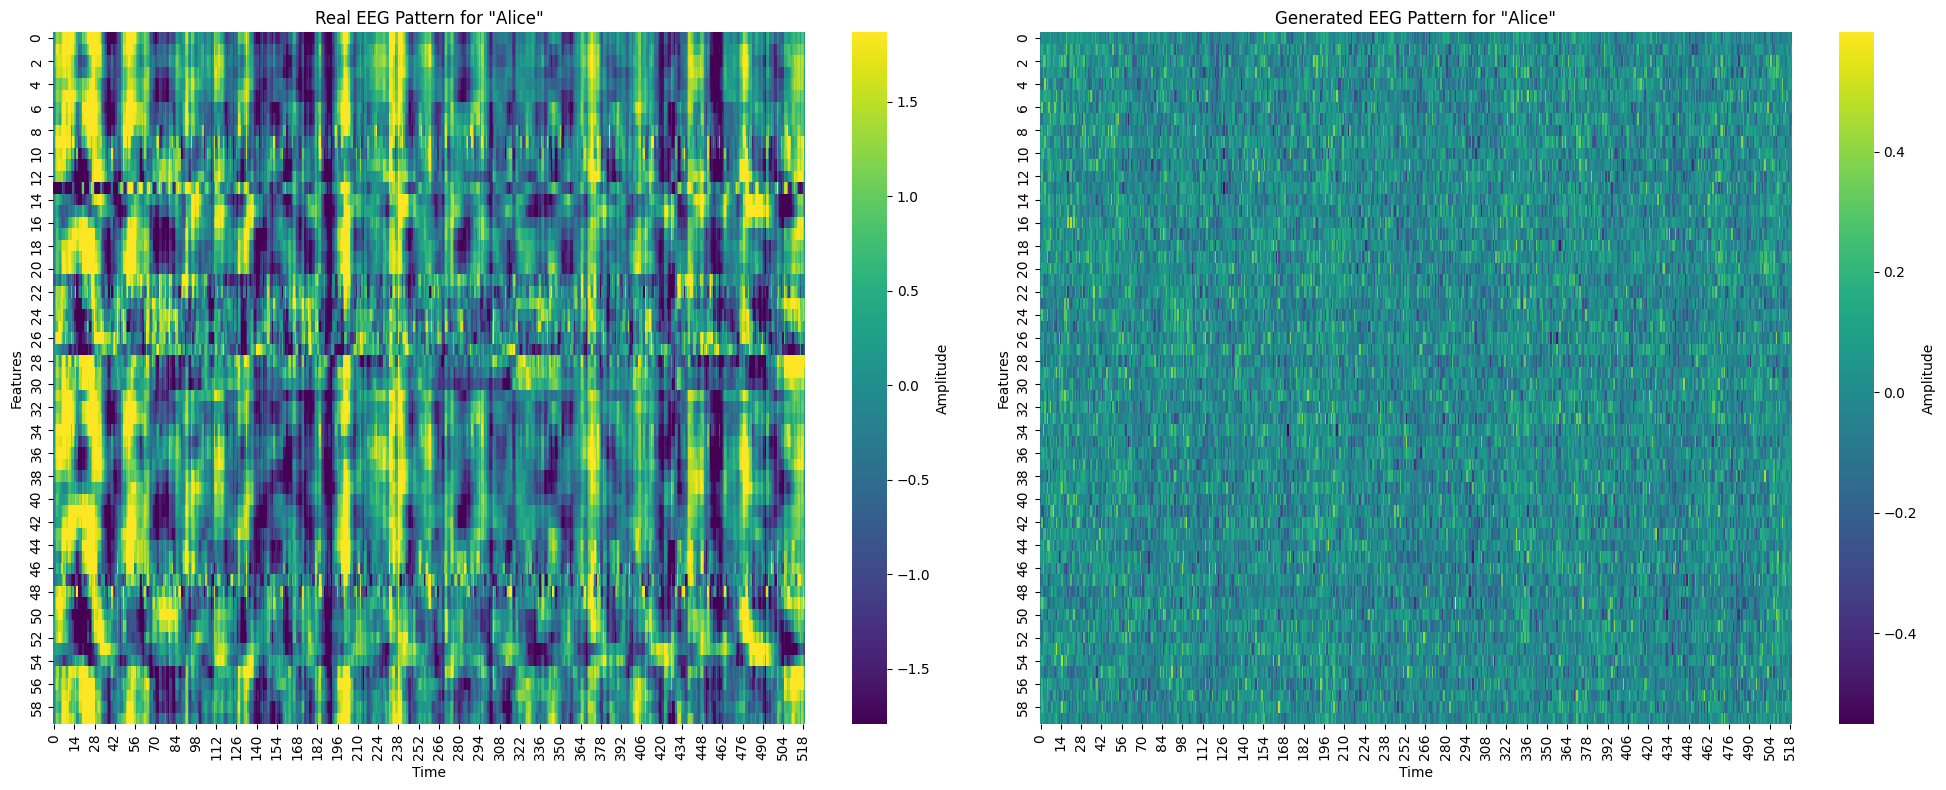

"plot_eeg_heatmaps(real_alice[1], generated_alice[1], 'Alice')\nplot_eeg_heatmaps(real_alice[2], generated_alice[2], 'Alice')\nplot_eeg_heatmaps(real_alice[3], generated_alice[3], 'Alice')"

In [30]:
plot_eeg_heatmaps(real_alice[0], generated_alice[0], 'Alice')
'''plot_eeg_heatmaps(real_alice[1], generated_alice[1], 'Alice')
plot_eeg_heatmaps(real_alice[2], generated_alice[2], 'Alice')
plot_eeg_heatmaps(real_alice[3], generated_alice[3], 'Alice')'''

In [66]:
real_think, generated_think = analyze_generated_samples(model, 'think', train_dataloder, num_samples=5)
plot_eeg_heatmaps(real_think[0], generated_think[0], 'think')
plot_eeg_heatmaps(real_think[1], generated_think[1], 'think')
plot_eeg_heatmaps(real_think[2], generated_think[2], 'think')

KeyboardInterrupt: 

In [9]:
model = torch.load('/ocean/projects/cis240129p/soederha/model1.pth')

/var/tmp/ipykernel_27641/3131038681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/ocean/projects/cis240129p/soederha/model1.pth')


In [15]:
def word_latent_dict(model, train_dataloder):
    """ Returns dict of label:latent """
    model.eval()
    device = next(model.parameters()).device
    
    word_latents_dict = {}
    
    with torch.no_grad():
        #j=0
        for batch in tqdm(train_dataloder):
            #j+=1
            labels = batch['label']
            eeg_feats = batch['eeg_raw'].float().to(device)
            
            for i, label in enumerate(labels):
                if label not in word_latents_dict:
                    word_latents_dict[label] = []
                
                eeg_sample = eeg_feats[i]
                mu, _ = model.encode(eeg_sample.unsqueeze(0))   #mu is shape [1, 64]
                word_latents_dict[label].append(mu)
                
            #if j>500:
            #    break
            
                
    for key in word_latents_dict:
        word_latents_dict[key] = torch.cat(word_latents_dict[key], dim=0)
        
    return word_latents_dict

def mean_std_latent_dict(word_latents_dict):
    ''' calculates mean and std for each word in word_latents_dict '''
    mean_latent_dict = {}
    std_latent_dict = {}
    
    for key in word_latents_dict:
        mean_latent_dict[key] = torch.mean(word_latents_dict[key], dim=0)
        std_latent_dict[key] = torch.std(word_latents_dict[key], dim=0)
        
    return mean_latent_dict, std_latent_dict

def word_augmentation_dict(mean_latent_dict, std_latent_dict, num_samples=100):
    """ Creates dict with word:generated_samples (shape #generated x time x features) """
    word_augmentation_dict = {}
    
    for key in mean_latent_dict:
        word_augmentation_dict[key] = []
        for i in range(num_samples):
            eps = torch.randn_like(std_latent_dict[key])
            z = mean_latent_dict[key] + eps * torch.sqrt(std_latent_dict[key])
            generated = model.decode(z.unsqueeze(0))
            word_augmentation_dict[key].append(generated)
            
        word_augmentation_dict[key] = torch.cat(word_augmentation_dict[key], dim=0)
    
    return word_augmentation_dict

In [ ]:
merged_datasets = torch.utils.data.ConcatDataset([train_dataset, test_dataset])
merged_loader = torch.utils.data.DataLoader(
    merged_datasets,
    batch_size=2,
    num_workers=1,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=True,
)

test_dict = word_latent_dict(model, merged_loader)

  0%|          | 0/5322 [00:00<?, ?it/s]

In [22]:
print(test_dict['pop'].shape)

torch.Size([5, 64])


In [23]:
test_avaraged_dict, test_std_dict = mean_std_latent_dict(test_dict)
print(test_avaraged_dict['pop'].shape)

torch.Size([64])


In [24]:
print(len(test_avaraged_dict))
print(len(test_std_dict))
print(len(set(test_avaraged_dict.keys())))

628
628
628


In [26]:
del test_dataloder, train_dataloder

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [33]:
!nvidia-smi

Thu Nov 28 20:22:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   27C    P0             52W /  300W |   32490MiB /  32768MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

|    0   N/A  N/A     10200      C   ...ared/conda/envs/gaddy/bin/python3.1      32486MiB |
+-----------------------------------------------------------------------------------------+


In [30]:
import gc

# Get reference to current model
current_model_id = id(model)

# Find and delete all other models
for obj in gc.get_objects():
    try:
        if isinstance(obj, EEGAutoencoder) and id(obj) != current_model_id:
            del obj
    except:
        pass

# Clear CUDA cache
torch.cuda.empty_cache()

/var/tmp/ipykernel_10200/340912137.py:9: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, EEGAutoencoder) and id(obj) != current_model_id:


In [32]:
import gc

# First delete all references to autoencoder models except current one
current_model_id = id(model)
for obj in gc.get_objects():
    try:
        if isinstance(obj, EEGAutoencoder) and id(obj) != current_model_id:
            del obj
    except:
        pass

# Clear all tensors currently cached
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            if obj.is_cuda:
                del obj
    except:
        pass

# Force garbage collection
gc.collect()

# Empty CUDA cache
torch.cuda.empty_cache()

# Print memory usage after cleanup
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f}MB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved()/1024**2:.2f}MB")

/var/tmp/ipykernel_10200/3085957998.py:7: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if isinstance(obj, EEGAutoencoder) and id(obj) != current_model_id:
/ocean/projects/cis240129p/shared/conda/envs/gaddy/lib/python3.10/site-packages/torch/__init__.py:1022: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)
/var/tmp/ipykernel_10200/3085957998.py:15: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


GPU memory allocated: 29052.61MB
GPU memory reserved: 32110.00MB


In [35]:
!nvidia-smi

Thu Nov 28 20:22:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   27C    P0             52W /  300W |   32490MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

/var/tmp/ipykernel_10200/3112602371.py:3: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):


<class 'torch.nn.parameter.Parameter'> torch.Size([64, 768000])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 768000])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([768000, 64])
<class 'torch.nn.parameter.Parameter'> torch.Size([768000])
<class 'torch.nn.parameter.Parameter'> torch.Size([32, 1, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.nn.parameter.Parameter'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([32])
<class 'torch.Tensor'> torch.Size([])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 32, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64])
<class 'tor

In [15]:
!nvidia-smi

Thu Nov 28 20:47:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:16:00.0 Off |                    0 |
| N/A   30C    P0             55W /  300W |     972MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [38]:
gc.collect()
torch.cuda.empty_cache()

In [95]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [36]:
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                        key=lambda x: -x[1])[:10]:
    obj = globals()[name]
    if torch.is_tensor(obj):
        print(f"{name}: {obj.size()} {'on GPU' if obj.is_cuda else 'on CPU'}")
    else:
        print(f"{name}: {size} bytes")

test_std_dict: 18520 bytes
_i10: 6695 bytes
_i6: 3744 bytes
_i7: 2138 bytes
tqdm: 2016 bytes
_: 1505 bytes
_10: 1505 bytes
BrennanDataset: 1480 bytes
_i5: 1338 bytes
_i4: 1231 bytes


In [37]:
import gc
import torch

# First move model to CPU temporarily
if 'model' in globals():
    model_cpu = model.cpu()
    del model

# Delete all GPU tensors
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj):
            if obj.is_cuda:
                print(f"Found GPU tensor of size {obj.size()}")
                del obj
        elif hasattr(obj, 'data') and torch.is_tensor(obj.data):
            if obj.data.is_cuda:
                print(f"Found GPU tensor in object of size {obj.data.size()}")
                del obj
    except:
        pass

# Clear cuda cache
torch.cuda.empty_cache()

# Force garbage collection
gc.collect()

# Move model back to GPU
if 'model_cpu' in globals():
    model = model_cpu.cuda()
    del model_cpu

# Print current memory usage
print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1024**3:.2f}GB")
print(f"GPU memory reserved: {torch.cuda.memory_reserved()/1024**3:.2f}GB")

/var/tmp/ipykernel_10200/2259399754.py:16: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  elif hasattr(obj, 'data') and torch.is_tensor(obj.data):


Found GPU tensor of size torch.Size([32])
Found GPU tensor of size torch.Size([32])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Size([64])
Found GPU tensor of size torch.Siz

In [25]:
def word_augmentation_dict(mean_latent_dict, std_latent_dict, num_samples, batch_size=1):
    word_augmentation_dict = {}
    
    for key in mean_latent_dict.keys():
        word_augmentation_dict[key] = []
        # Process in smaller batches
        for i in range(0, num_samples, batch_size):
            current_batch_size = min(batch_size, num_samples - i)
            eps = torch.randn(current_batch_size, *std_latent_dict[key].shape, device=std_latent_dict[key].device)
            z = mean_latent_dict[key].unsqueeze(0) + eps * torch.sqrt(std_latent_dict[key].unsqueeze(0))
            generated = model.decode(z)
            word_augmentation_dict[key].append(generated)
            # Free memory
            torch.cuda.empty_cache()
            
        word_augmentation_dict[key] = torch.cat(word_augmentation_dict[key], dim=0)
    
    return word_augmentation_dict

In [106]:
torch.save(model, '/ocean/projects/cis240129p/soederha/model1.pth')

In [11]:
model = torch.load('/ocean/projects/cis240129p/soederha/model1.pth')

/var/tmp/ipykernel_10200/3131038681.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/ocean/projects/cis240129p/soederha/model1.pth')


In [ ]:
torch.save(model, 'complete_model.pth')

In [27]:
del test_augmentation_dict

In [29]:
test_augmentation_dict = word_augmentation_dict(test_avaraged_dict, test_std_dict, num_samples=1)

In [30]:
print(test_augmentation_dict['you'].shape)

torch.Size([1, 159, 300])


In [32]:
alice_chapter = pd.read_csv('/ocean/projects/cis240129p/shared/data/eeg_alice/AliceChapterOne-EEG.csv').iloc[:,0]
new_subject = np.empty((159*len(alice_chapter), 300))
for i in range(len(alice_chapter)):
    word = alice_chapter[i]
    if word not in test_augmentation_dict:
        print(f"Word '{word}' not found in augmentation dict")
    else:
        #random_coice = np.random.randint(0, 5)
        random_coice = 0
        new_subject[i*159:(i+1)*159] = test_augmentation_dict[word][random_coice].cpu().detach().numpy()
        
print(new_subject.shape)
print(new_subject)
    

(338511, 300)
[[ 0.41454279  0.89457947  0.08126186 ...  0.12161036  0.28964347
   0.22715439]
 [ 0.80020154  0.75679547  0.07246543 ...  0.32226649  0.51838607
   0.14479505]
 [ 0.8193599   1.21391559 -0.39875561 ...  0.67561072  0.28513384
   0.19971155]
 ...
 [ 0.13928281  1.00029242  0.11379306 ...  0.44294843  0.15061973
   0.40336108]
 [ 0.09833036  0.83921272  0.35256317 ...  0.33082393  0.080521
   0.32564172]
 [ 0.3243438   0.72175211  0.47407043 ...  0.34398735  0.0509107
   0.303657  ]]


In [35]:
#create .npy file from the new subject
np.save('/ocean/projects/cis240129p/soederha/newsubject_model9_1word_feats.npy', new_subject)